# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Bailey Belinger, Camila Monter, Priya Shah

**IDs**: 5277347 (bcb87), 5244001 (cm755), 5244508 (ps742)

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [79]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/hw5-last-3-brain-cells-1`


In [80]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

### Derivation ###

**Decision Variables:**

- $W_{i,j}$: Waste (Mg/day) transported from city $i$ to facility $j$.
- $R_{k,j}$: Residual waste (Mg/day) transported from facility $k$ to another facility $j$.
- $Y_j$: Binary variable indicating whether facility $j$ is operational (1 if operational, 0 otherwise).

**Objective Function:**

Minimize the total cost:

$ \text{Total Cost} = \text{Transport Cost} + \text{Disposal Cost} + \text{Fixed Cost} $

Where:

Transport Cost:

$ \sum_{i=1}^3 \sum_{j=1}^3 \text{Transport}_{i,j} \cdot W_{i,j} + \sum_{k=1}^3 \sum_{j=1}^3 \text{Residual Transport}_{k,j} \cdot R_{k,j} $

Disposal Cost:

$ \sum_{j=1}^3 \left( \text{Tipping Fee}_j \cdot \sum_{i=1}^3 W_{i,j} + \text{Recycling Cost}_j \cdot \text{Recycled Waste}_j \right) $

Fixed Cost:

$ \sum_{j=1}^3 \text{Fixed Cost}_j \cdot Y_j $

**Constraints:**

Mass-Balance Constraints for Cities: Each city’s waste must be allocated:

$ \sum_{j=1}^3 W_{i,j} = \text{Production}_i, \quad \forall i \in \{1, 2, 3\} $

Residual Waste Constraints: For facilities with residuals, the residual flow must account for ash fractions:

$ \sum_{k=1}^3 R_{k,j} = \text{Residual Ash}, \quad \text{as per facility-specific ash rates.} $

Capacity Constraints: The total waste processed at each facility must not exceed its capacity:

$ \sum_{i=1}^3 W_{i,j} + \sum_{k=1}^3 R_{k,j} \leq \text{Capacity}_j \cdot Y_j, \quad \forall j \in \{1, 2, 3\} $

Binary Commitment Constraints: Facilities are operational only if waste is transported to them:

$ W_{i,j} \leq M \cdot Y_j, \quad R_{k,j} \leq M \cdot Y_j $

Non-Negativity Constraints: All decision variables must be non-negative:

$ W_{i,j}, R_{k,j} \geq 0 $

Big-M Constraint:

$ M $ is a sufficiently large number ensuring that the constraint holds when $ Y_j = 1 $.




In [81]:
I = 1:3
J = 1:3
K = 1:3

l = [5 30 15; 15 25 10; 13 45 20] # Distance between source i and disposal j (km)
a = 1.5 .* l # Cost of transporting waste from source i to disposal j ($/Mg-km)
c = [2000 1500 2500] # Fixed costs of operating disposal j ($/day)
b = [50 7 60] # Variable cost of disposing waste at disposal j ($/Mg)
MRF_recylcing_rate = 0.4 
MRF_recylcing_cost = 40
recycling = [0 (MRF_recylcing_rate * MRF_recylcing_cost) 0] # recycling costs at disposal j 
residuals = [0 32 18; 32 0 15; 18 15 0] # distance between facilities (km)
residual_cost = 1.5 .* residuals # Cost of transporting waste from disposal k to disposal j ($/Mg-km)
WTE_Residual_Ash = 0.16
Ash_Recylced = 0.14
production = [100 90 120] # solid waste production at each city i (Mg/day)
disposal_limit = [200 350 210] # capacity of each disposal j (Mg)

MSW_model = Model(HiGHS.Optimizer)

# Waste Management Decision Variables
@variable(MSW_model, W[i in I, j in J] >= 0)  # Waste transported from city i to disposal j (Mg/day)
@variable(MSW_model, R[k in K, j in J] >= 0)  # Residual waste transported from disposal k to disposal j (Mg/day)
@variable(MSW_model, Y[j in J], Bin)  # Operational status (on/off) of disposal j (binary)

# Objective Functions 
transpo_cost = sum(a[i, j] * W[i, j] for i in I, j in J) + (residual_cost[2,1] * R[2,1]) + (residual_cost[2, 3] * R[2, 3]) + (residual_cost[3, 1] * R[3, 1])
dispo_cost = sum(c[j] * Y[j] + sum(b[j] * W[i, j] for i in I) + sum(recycling[j] * W[i, j] for i in I) for j in J) + (b[1] * R[2,1]) + (b[1] * R[3,1]) + (b[3] * R[2,3])
@objective(MSW_model, Min, sum(transpo_cost + dispo_cost))

# Constraints 
# Residual Flow Constraint
#=allowed_pairs = [(3, 1), (2, 3), (2, 1)]
# before: @constraint(MSW_model, residual_flow_contraint, [k in K, j in J; (k, j) ∉ allowed_pairs], R[k, j] == 0)
for k in K, j in J
    if (k, j) ∉ allowed_pairs
        @constraint(MSW_model, R[k, j] == 0)
    end
end
=#

@constraint(MSW_model, R_constraint, R[1,1] + R[1,2] + R[1,3] + R[2,2] + R[3,2] + R[3,3] == 0)

# City Mass-Balance Constraints
# before: @constraint(MSW_model, city_mb_contraint, sum(W[i, j] for j in J) == production[i] for i in I)
@constraint(MSW_model, city_mb_contraint1, sum(W[1, j] for j in J) == production[1])
@constraint(MSW_model, city_mb_contraint2, sum(W[2, j] for j in J) == production[2])
@constraint(MSW_model, city_mb_contraint3, sum(W[3, j] for j in J) == production[3])

# Residual Mass-Balance Constraints
@constraint(MSW_model, residual_WTE_mb_contraint, R[3, 1] == (WTE_Residual_Ash * (sum(W[i, 1] for i in I))) + (Ash_Recylced * R[2,3]))
@constraint(MSW_model, residual_MRF_mb_contraint, R[2, 1] + R[2, 3] == ((1 - MRF_recylcing_rate) * (sum(W[i, 2] for i in I))))

# Disposal Limit Constraint
# before: @constraint(MSW_model, disposal_limit_contraint, sum(W[i, j] for i in I) + sum(R[k, j] for k in K) <= disposal_limit[j] for j in J)
@constraint(MSW_model, disposal_limit_contraint1, sum(W[i, 1] for i in I) + R[2,1] + R[3,1] <= disposal_limit[1])
@constraint(MSW_model, disposal_limit_contraint2, sum(W[i, 2] for i in I) <= disposal_limit[2])
@constraint(MSW_model, disposal_limit_contraint3, sum(W[i, 3] for i in I) + R[2,3] <= disposal_limit[3])

#=
# Commitment Constraints
@constraint(MSW_model, Y3_constraint, !Y[3] => {W[1,3] + W[2,3] + W[3,3] + R[2,3] == 0})
@constraint(MSW_model, Y2_constraint, !Y[2] => {W[1,2] + W[2,2] + W[3,2] == 0})
@constraint(MSW_model, Y1_constraint, Y[1] == 1)
=#

# Big-M Constraints for Commitment
M = 10000  # Choose a sufficiently large value for 
@constraint(MSW_model, bigM_Y1, W[1,1] + W[2,1] + W[3,1] + R[3,1] + R[2,1] <= M * Y[1])
@constraint(MSW_model, bigM_Y2, W[1,2] + W[2,2] + W[3,2] <= M * Y[2])
@constraint(MSW_model, bigM_Y3, W[1,3] + W[2,3] + W[3,3] + R[2,3] <= M * Y[3])


print(MSW_model)


Min 57.5 W[1,1] + 72.5 W[2,1] + 69.5 W[3,1] + 68 W[1,2] + 60.5 W[2,2] + 90.5 W[3,2] + 82.5 W[1,3] + 75 W[2,3] + 90 W[3,3] + 98 R[2,1] + 82.5 R[2,3] + 77 R[3,1] + 2000 Y[1] + 1500 Y[2] + 2500 Y[3]
Subject to
 R_constraint : R[1,1] + R[1,2] + R[2,2] + R[3,2] + R[1,3] + R[3,3] = 0
 city_mb_contraint1 : W[1,1] + W[1,2] + W[1,3] = 100
 city_mb_contraint2 : W[2,1] + W[2,2] + W[2,3] = 90
 city_mb_contraint3 : W[3,1] + W[3,2] + W[3,3] = 120
 residual_WTE_mb_contraint : -0.16 W[1,1] - 0.16 W[2,1] - 0.16 W[3,1] + R[3,1] - 0.14 R[2,3] = 0
 residual_MRF_mb_contraint : -0.6 W[1,2] - 0.6 W[2,2] - 0.6 W[3,2] + R[2,1] + R[2,3] = 0
 disposal_limit_contraint1 : W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] ≤ 200
 disposal_limit_contraint2 : W[1,2] + W[2,2] + W[3,2] ≤ 350
 disposal_limit_contraint3 : W[1,3] + W[2,3] + W[3,3] + R[2,3] ≤ 210
 bigM_Y1 : W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] - 10000 Y[1] ≤ 0
 bigM_Y2 : W[1,2] + W[2,2] + W[3,2] - 10000 Y[2] ≤ 0
 bigM_Y3 : W[1,3] + W[2,3] + W[3,3] + R[2,3] -

In [82]:
optimize!(MSW_model)
@show objective_value(MSW_model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+04]
  Cost   [6e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 4e+02]
Presolving model
10 rows, 15 cols, 43 nonzeros  0s
8 rows, 13 cols, 32 nonzeros  0s

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   32 nonzeros
MIP-Timing:     0.00024 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

      

28439.655172413793

In [83]:
@show W11 = value.(W[1,1])
@show W12 = value.(W[1,2])
@show W13 = value.(W[1,3])
@show W21 = value.(W[2,1])
@show W22 = value.(W[2,2])
@show W23 = value.(W[2,3])
@show W31 = value.(W[3,1])
@show W32 = value.(W[3,2])
@show W33 = value.(W[3,3])
@show Y1 = value.(Y[1])
@show Y2 = value.(Y[2])
@show Y3 = value.(Y[3])
@show R31 = value.(R[3,1])
@show R23 = value.(R[2,3])
@show R21 = value.(R[2,1])

#Adjacency matrix
mat = [0 0 0 W11 W13; 
       0 0 0 W21 W23;
       0 0 0 W31 W33;
       0 0 0 R21 1;
       0 0 0 0 0]

rows, cols = size(mat)

# Initialize the new matrix A with zeros
A = zeros(Int, rows, cols)
       
# Loop through each element in the matrix
       for i in 1:rows
           for j in 1:cols
               if mat[i, j] != 0
                   A[i, j] = 1  # Set to 1 if the value in mat is non-zero
               end
           end
       end
       
       # Display the result
       println("Matrix A:")
       display(A)


5×5 Matrix{Int64}:
 0  0  0  1  0
 0  0  0  0  1
 0  0  0  1  1
 0  0  0  0  1
 0  0  0  0  0

W11 = value.(W[1, 1]) = 100.0
W12 = value.(W[1, 2]) = 0.0
W13 = value.(W[1, 3]) = -0.0
W21 = value.(W[2, 1]) = 0.0
W22 = value.(W[2, 2]) = -0.0
W23 = value.(W[2, 3]) = 90.0
W31 = value.(W[3, 1]) = 72.4137931034483
W32 = value.(W[3, 2]) = 0.0
W33 = value.(W[3, 3]) = 47.58620689655171
Y1 = value.(Y[1]) = 1.0
Y2 = value.(Y[2]) = -0.0
Y3 = value.(Y[3]) = 1.0
R31 = value.(R[3, 1]) = 27.58620689655173
R23 = value.(R[2, 3]) = 0.0
R21 = value.(R[2, 1]) = 0.0
Matrix A:


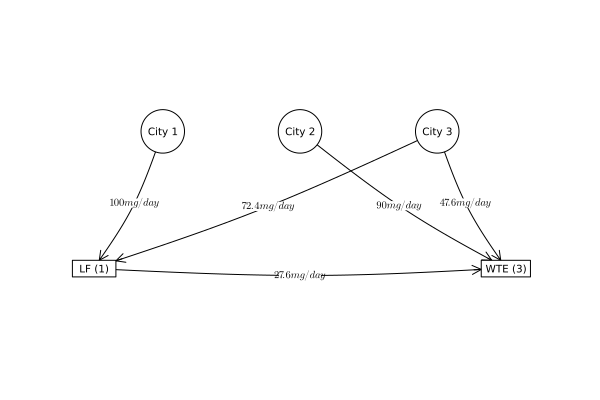

In [84]:
#import Pkg; Pkg.add("LaTeXStrings")
using GraphPlot
using LaTeXStrings  # Import for LaTeX formatting in labels
using Printf

# Node names
names = ["City 1", "City 2", "City 3", "LF (1)", "WTE (3)"]

#### works but not right
edge_labels = Dict(
    (1, 4) => L"100mg/day",
    (2, 5) => L"90mg/day",
    (3, 4) => L"72.4mg/day",
    (3, 5) => L"47.6mg/day",
    (4, 5) => L"27.6mg/day",
)

# Node positions (updated to match six nodes)
xpos = [-1, 0, 1, -1.5, 1.5]  # Add positions for MRF and WTE
ypos = [2, 2, 2, 1, 1, 1]  # Add positions for MRF and WTE

# Node shapes
shapes = [:ellipse, :ellipse, :ellipse, :rect, :rect, :rect]

# Plotting the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.15,
    markershapes=shapes,
    markercolor=:white,
    x=xpos,
    y=ypos
)
display(p)

### Solution ###

The MRF faciliity will not be used (Y2 = 0.0)

While the MRF has a low tipping fee of $7/Mg and sufficient capacity of 350 Mg/day, its high transportation costs due to its distance from all three cities make it less competitive. When accounting for recycling costs and the need to transport residual waste (with a 14% ash fraction) to other facilities, the total cost of using the MRF exceeds that of the landfill and waste-to-energy facility. Additionally, the landfill and waste-to-energy facility are more centrally located and operationally simpler, making them more favorable options. Given these factors, the decision not to use the MRF is reasonable.

## References

List any external references consulted, including classmates.